In [ ]:
%matplotlib inline
# Import classical data science packages
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm, datasets
import cmath


# Quantum packages
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile


In [ ]:
# IGNORE THESE

# Utility Functions that we don't need to show in the Jupyter notebook
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import cmath

def plot_bloch(theta, phi, labels):

    # Input: theta, phi - Arrays containing the theta and phi coordinates for the bloch sphere representation of a statevector for each datapoint.
    # Output : None - Plots a 3D graph
    r = 1.0
    
    xs = r*np.sin(theta)*np.cos(phi)
    ys = r*np.sin(theta)*np.sin(phi)
    zs = r*np.cos(theta)
    
    " Create the sphere outline "
    
    phi_outline = np.linspace(0, np.pi, 100)
    theta_outline = np.linspace(0, 2*np.pi, 100)
    phi_outline, theta_outline = np.meshgrid(phi_outline, theta_outline)
    
    x = np.sin(phi_outline) * np.cos(theta_outline)
    y = np.sin(phi_outline) * np.sin(theta_outline)
    z = np.cos(phi_outline)
    
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, color="w", rstride=1, cstride=1, linewidth=0, alpha=0.3)
    
    
    " Plot our pointson the graph"
    
    color= ['red' if l == 0 else 'green' for l in labels]
    ax.scatter(xs,ys,zs,color=color,s=20)
    
    
    
    plt.show()
    
    
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               #levels=[-1, 0, 1], alpha=0.5,
               levels=[ 0 ], alpha=0.5,
               #linestyles=['--', '-', '--'])
               linestyles=['-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
# Find accuracy of model
def accuracy_score(model, x, labels):
    predictions = model.predict(x)
    predictions = predictions.reshape(len(predictions), 1)
    labels = labels.reshape(len(labels), 1)
    correct = predictions == labels
    accuracy = sum(correct) / len(correct)
    print("Accuracy score is ", np.round(accuracy[0],3)*100, "%")
    
    
# HIDE THIS
def get_statevector(x_data_array, quantum_circuit):
    # This function takes some classical input data and a quantum circuit
    
    #Input : x_data_array - An array containing all the classical datapoint
    #Input : quantum_circuit - The quantum circuit to pass the classical data into
    #Output : statevector_array - An array containing the quantum statevector for each datapoint
    " The entire circuit is constructed here and the statevector generated"       
    statevector_array = [None] * len(x_data_array)

    num_qubits = 1
    
    # Cycle through each datapoint and run it through the quantum circuit.
    for i in range(len(x_data_array)):

        sub_inst_U = quantum_circuit(x_data_array[i])
        
        qr = QuantumRegister(num_qubits, 'qr')
        cr = ClassicalRegister(num_qubits, 'cr')
        circ_U = QuantumCircuit(qr, cr)
        

   

        circ_U.append(sub_inst_U, qr)
            
        # Select the StatevectorSimulator from the Aer provider
        simulator = Aer.get_backend('statevector_simulator')
        # Execute and get counts
        result = execute(circ_U, simulator).result()
        statevector = result.get_statevector(circ_U)

        statevector_array[i] = statevector

    return statevector_array

# HIDE THIS
def find_bloch_coordinates_from_statevector(statevector_array):
    # Convert the statecetor into theta and phi bloch sphere coordinates.
    
    #Input : statevector_array - An array consisting of th quantum statevectors corresponding to each datapoint
    # Output: theta, phi - Arrays containing the theta and phi coordinates for the bloch sphere representation of a statevector for each datapoint.
    alpha = statevector_array[:, 0]
    beta = statevector_array[:, 1]
    
    max_alpha = (max(abs(alpha)))
    theta = 2 * np.arccos(abs(alpha) / max(max_alpha, 1))
    
    phi = [0] * len(theta)
    for i in range(len(phi)):
        phi[i] = cmath.phase(beta[i]) - cmath.phase(alpha[i])
        phi = np.array(phi)
    theta = theta.reshape((len(theta), 1))
    phi = phi.reshape((len(phi), 1))
    return theta, phi

This is the QSVM introductory task. We will focus on understanding conceptually what a QSVM hopes to achieve and indicate where the quantum advantage may arise from. In order to show visually what is happening we are also going to have to limit ourselves to 1 qubit in order to create some nice visualisations using the Bloch sphere represntation. 

First of all we will introduce the classical SVM and show a simple visual example of it in action. The data here will consist of 1 dimensional data.

In [ ]:
# Here is the very baisc 1D data we will work with in this first example
data_classic = np.array([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
labels_classic = np.array([0, 0, 0, 0 , 1, 1, 1, 1, 1, 0, 0, 0, 0])
# Plottig this 1D data shows the following
zero_array =  np.zeros(data_classic.size)
plt.scatter(data_classic, zero_array, c=labels_classic, s=50, cmap='winter')

This data is purely 1 dimensional. We now encode the data into a higher dimensional space, for example 2 dimensions.

In [ ]:
# This is just some necessary reformatting of the data to get it in the right format
labels_classic = np.transpose(labels_classic)
data_classic_plot = np.vstack([data_classic, zero_array])
data_classic_plot = np.transpose(data_classic_plot)

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
# SVC gives us a classical support vector machine classifier
# Here the kernel='linear' means we don't use a kernel that we are just trying to separate whatever we input with a straight line
model = SVC(kernel='linear', C=10)
# This step trains an SVM model using our data
model.fit(data_classic_plot, labels_classic)

Performing a SVM on this 1 dimensional data will result in a decision boundary that produces the following decision boundary: 
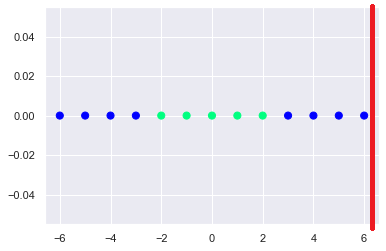
(For visibility purposes I have drawn this line on because running the actual model puts the decision boundary at some value >>10000. However we can print the predictions below and see that the SVM does infact classify all the points as the same label) 

In [ ]:
accuracy_score(model, data_classic_plot, labels_classic)
pred = model.predict(data_classic_plot)
print("Class predictions are : ",pred)

In this case the decision boundary is beyond the end of the data and all the data is simply labelled as class 0 (blue in this case). This results in a rather trivial accuracy score of 61.5% for the data (only >50% by virtue of there being more blue than green points).


Task 1:

We want to now implement a feature map which will take the data from 1 dimension to 2 dimensional space. We are going to implement this classically and explicitly. 

The data will be transformed from 1D point [x] to a 2D point [x, f(x)] where f(x) is a function you need to write below.

Run the next line of code to see the effect of your encoding function 

In [ ]:
def encoding_function(x):
    # enter code here
    # ==============
    # ==============
    
    # y = f(x)
    

    
    # ==============
    # ==============
    return y

In [ ]:
# Test your encoding function here to see how it transforms the data
encoded_data = encoding_function(data_classic)
data_to_plot = np.vstack([data_classic, encoded_data])
data_to_plot = np.transpose(data_to_plot)
plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1], c=labels_classic, s=50, cmap='winter')

Your encoding function should result in the points being plotted in 2D. If an appropriate encoding function was used then the points should now be seperable by a single straight line drawn on the graph. In order to test this run the next line.

In [ ]:
# SVC
# We train a classical SVM
# Note the kernel='linear' which means basically not using a kernel in the SVM method. However we are passing the data
# after it has been encoded into a higher dimensional state already. So we are in effect doing the kernel part of the
# SVM algorithm for it.
model = SVC(kernel='linear', C=1)
model.fit(data_to_plot, labels_classic)

# The data is now plotted along with the decision boundary of the SVM
plt.scatter(data_to_plot[:, 0], data_to_plot[:, 1], c=labels_classic, s=50, cmap='winter')
# This function retrieves the decision boundary from the SVM model object and plots the line on the graph
plot_svc_decision_function(model)
accuracy_score(model, data_to_plot, labels_classic)

You should find an accruacy score of 100.0%, and clearly see the data is well separated by a straight line!
In general an SVM can encode data to a higher dimensional space and then seperate it by a hyperplane in that higher dimensional space.

The above method was shown to give some insight into how an SVM method works. We encoded data into a higher dimensional space explicitly, then used the SVM to find a line that seperated the points in this space.

However, one of the key advtanages of the SVM is something called the "kernel trick". Where instead of explicitly finding the encoding in the higher dimensional space, we can instead work out s Clomething called the kernel matrix for the data.

The kernel matrix entry (i,j) for datapoint (i) with datapoint (j) is equal to the inner product between (i) encoded in the higher dimensional space, with (j) encoded in the higher dimensional space.

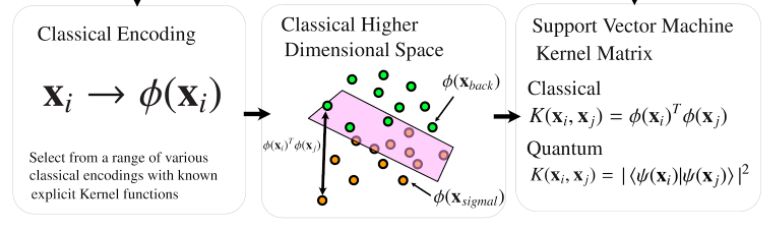

There will be times where calculating the higher dimensional encoding is difficult or impossible. However the kernel will be possible to calculate. Classically the RBF kernel defined:
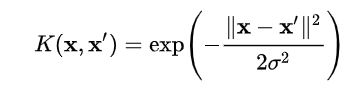
Is a simple expression when shown as a Kernel entry formula. However it would be more difficult to represent the classical encoding that would generate this kernel

Task 2:

Create a function that create the kernel matrix that corresponds to your encoding function in the previous task. Note that the kernel entry is defined by:

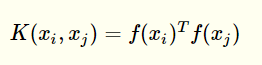

Where f is the higher dimensional encoding function.

In [ ]:
# We don't need to actually find the higher dimensional encoding, only the kernel matrix

def classical_kernel(X1, X2):
    kernel = np.zeros(((len(X1)), (len(X2))))
    for index_1 in range(len(X1)):
        for index_2 in range(len(X2)):
            
            # The datapoints in question here are X1[index_1] and X2[index_2]
            # The kernel entry is the dot product between two relevent datapoints after they have been encoded into the 
            # higher dimensional space, as shown in the above equation.
            
            # ENTER YOUR CODE HERE
            # ====================
            # ====================

            
            
            # ====================
            # ====================
            
            # The final output is kernel entry, which will fill the kernel_matrix at position kernel[index_1, index_2]
            
            kernel[index_1, index_2] = kernel_entry
    return kernel
            
# Hint : The encoded form of the data was [x, f(x)]
# 

In [ ]:
# If you are stuck here is the answer to task 2. Just take this time to understand what the code is doing.

# SPOILER
# SPOILER
# SPOILER
# SPOILER
# SPOILER
# SPOILER
# SPOILER


def classical_kernel_answer(X1, X2):
    kernel = np.zeros(((len(X1)), (len(X2))))
    for index_1 in range(len(X1)):
        for index_2 in range(len(X2)):
            vector_1 = np.array([X1[index_1], encoding_function(X1[index_1])])
            vector_2 = np.array([X2[index_2], encoding_function(X2[index_2])])
            kernel_entry = np.dot(vector_1.T , vector_2)
            kernel[index_1, index_2] = kernel_entry
    return kernel
            
# Hint : The encoded form of the data was [x, f(x)]

We can now test this kernel by running the classical SVM again. But this time we will input the original 1D data but specify to use the kernel that we just implemented.

We should get a 100.0% accuracy rate again.

Note that in this method we don't have to explicitly calculate the higher dimensional encoding (although in this case we may have done because the encoding is so simple).

In [ ]:
model = SVC(kernel=classical_kernel, C=1)
model.fit(data_classic, labels_classic)
accuracy_score(model, data_classic, labels_classic)

Now we will transition over to considering the QSVM. With n qubits it is possible to encode classical data into a 2^n dimensional hilbert space. This higher dimensional space could allow better classification of the data.

We shall start with the most simple case, using 1 qubit only. This will allow the most intuitive understanding as it is effectively the same problem we have just seen classically. We will be encoding 1 dimensional classical data into the 2 dimensional hilbert space of a qubit, the separation is then performed here.

In [ ]:
# Here we load up some data that corresponds to the points [pi/8, 2pi/8, 3pi/8, 4pi/8]
data_list = []
labels = [0, 1, 0, 1]
for index_x in range(4):
    variable = [(index_x + 1) * np.pi / 8]  
    data_list.append(variable)
zero_array = np.zeros(4)
plt.scatter(data_list, zero_array, c=labels, s=50, cmap='winter')

We will now approach this using a QSVM. If we remember the process shown below:

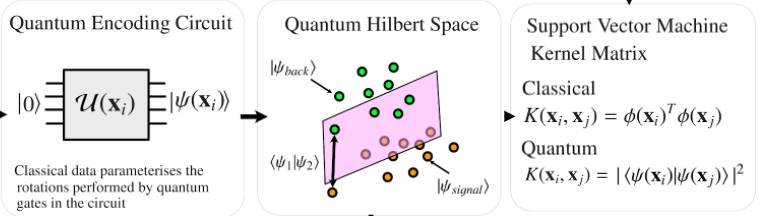

We are now using a quantum circuit, where the gates in the circuit are parameterised by the classical data. This forms a quantum state which will exist in a 2^n dimensional quantum hilbert space (where n is the number of qubits). We then perform the separation in this space. 

In practise this will involve finding the kernel matrix, as quantum states themselves cannot be input into classical algorithms. The inner product between quantum states however is just a real number though and thus the kernel matrix can be passed into a classical SVM.

However, in this exercise we will use the statevecotr_simulator (which allows us to find the exact quantum state of quantum simulations) in order to plot the quantum states on the bloch sphere of a qubit. This will be purely for demonstration purposes though, in order to gain some intuition to what is happening in the quantum SVM. In a real QSVM implementation we would not bother finding the quantum encoding explicitly and would just go straight to calculating the kernel matrix.

Here we will just remind you about the bloch sphere represenatation of a qubit:

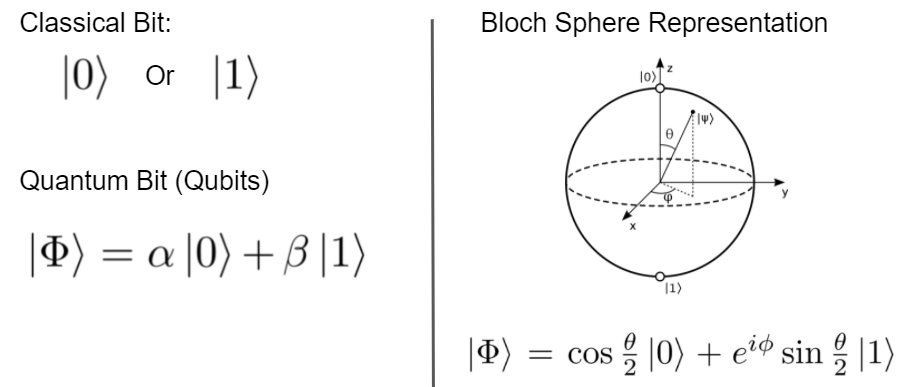

On the left is the standard way of representing a qubit in terms of alpha and beta. Where alpha^2 is the probability of measuring a 0 result and beta^2 is the probability of measuring a 1 result.

However, we can easily reprhase this in terms of theta and phi as shown on the right. This is called the bloch sphere representation and it means the qubit can be represented graphically as a point on the unit sphere.


Task 3:

We want to encode the data in one of the simplest possible ways. This basica circuit will soley use a Y rotation gate. The rotation amount will be equal to the classical datapoints (which are [pi/8, 2pi/8, 3pi/8, 4pi/8]).

If we plot these quantum states on the bloch sphere they should therefore form points along an arc of the bloch sphere.

You are given an empty circuit and you need to add the following gate to it:

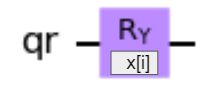

This should lead to the points being encoded to quantum states that are rotated pi/8 from each other on the bloch sphere of a qubit. This should look like this:



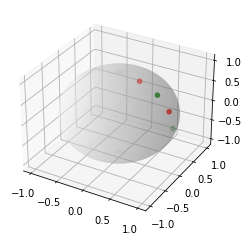

In [ ]:
def basic_kernel_circuit(x):
    # DO NOT EDIT THIS CIRCUIT 
    # This performs a very simple 1D encoding by performing a rotation about the y axis
    # by an amount equal to the classical data.
    
    # Set up quantum register
    qregister = QuantumRegister(1, 'qregister')
    circuit = QuantumCircuit(qregister, name='circuit')

    
    # Encode the classical data into a rotation angle about the Y axis.
    # ENTER YOUR CODE HERE
    # ======================
    # ======================
    
    # You need to rotate the circuit called "circuit" about the y axis by an amount "x[0]" in the register called "qregister[0]"
    # i.e. the first qubit (and only qubit in this case).
    

    # ======================
    # ======================

    
    
    # This last step is just to store the circuit object in a cetain manner to make it easier to use in various ways later.
    circuit = circuit.to_instruction()

    return circuit

In [ ]:
# Check the circuit that you coded by running this
# This will draw the circuit for the given datapoint in the array
datapoint_to_draw = 0
print("Outputting circuit for datapoint", datapoint_to_draw, " which is = ", data_list[datapoint_to_draw])

# Draw circuit
# This loads the circuit you programmed above as a sub-instruction
sub_inst_U = basic_kernel_circuit(data_list[datapoint_to_draw])
# Here we initiate a quantum register with 1 qubit
qr = QuantumRegister(1, 'qr')
# This initiates a quantum circuit object using that quantum register
circ_U = QuantumCircuit(qr)
# Here we append the sub-insturction previously loaded (i.e. the circuit you coded above) ontp the quantum circuit
circ_U.append(sub_inst_U, qr)
# Finally we draw the circuit
circ_U.decompose().draw('mpl')     

In [ ]:
# This will plot the 1D data onto the bloch sphere by performing a rotation on the bloch sphere

# The function get_statevector will use the statevector_simulator. This will simply run each entry in data_list, through the 
# circuit given by basic_kernel_circuit, and output the mathematically correct quantum state (this is only possible in simulations)
statevector_array = np.array(get_statevector(data_list, basic_kernel_circuit))
# This next function will convert the standard statevector representation of a qubit (alpha, beta) to theta and phi angles of the bloch sphere of a qubit
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
# This final function simply plots the points bloch sphere coordinates onto a unit sphere. 
plot_bloch(theta, phi, labels)

This is one of the most simple encoding circuits and we can see that the 1D data has simply been distributed over a circle on the bloch sphere of the qubit. However this will not be helpful as the datapoints are not easily seperable. In fact it isn't any more usful than the original 1D encoding...



Task 4:

Make an adjustment to the kernel_circuit below in order to cause the red and green points to become seperated from each other.

You can just use trial and error, but it is also possible to work out on pen and paper before entering any code by considering the symmettery of the problem.

In [ ]:
def kernel_circuit(x):

    # Initialise the quantum circuit
    qregister = QuantumRegister(1, 'qregister')
    circuit = QuantumCircuit(qregister, name='circuit')


    # WRITE CODE HERE
    # ==================================
    # ==================================
    
    # Make edits to the code here to create a circuit that will seperate the data
    # As a starting point we have just left the same circuit as you created in the previous task.
    
    circuit.ry(x[0], qregister[0])

    # ==================================
    # ==================================
    
    circuit = circuit.to_instruction()

    return circuit



In [ ]:
# Check the circuit that you coded by running this
# This will draw the circuit for the given datapoint in the array
datapoint_to_draw = 0
print("Outputting circuit for datapoint", datapoint_to_draw, " which is = ", data_list[datapoint_to_draw])

# Draw circuit
sub_inst_U = kernel_circuit(data_list[datapoint_to_draw])
qr = QuantumRegister(1, 'qr')
circ_U = QuantumCircuit(qr)
circ_U.append(sub_inst_U, qr)
circ_U.decompose().draw('mpl')

In [ ]:
# Run this code to see the encoding effect of your circuit
# This calculates the quantum states using your circuit and then plots them in the bloch sphere representation
statevector_array = np.array(get_statevector(data_list, kernel_circuit))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels)

Hopefully it should be very visible from this bloch sphere that the datapoints are now seperable!

However, SVMs can't accept quantum states as inputs... But they can accept a kernel formed by finding the inner product between two quantum states.

If we remember that the quantum state encoding is the quantum circuit, parameterised by the classical variables, applied to a 0 state:

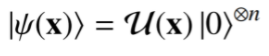


Then if we want to find the inner product between two points that have been encoded into a quantum state we simplyg need to take the complex conjugate of one side and append it on:



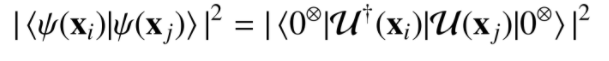

First we need to append the circuit as normal using parameters of datapoint i. Then we append the conjugate circuit using the parameters of datapoint j. Finally we measure to find the 0 state.

We repeat over many "shots" of the circuit and find the proportion of times we measured the 0 state. This is then the kernel entry for datapoint i with the datapoint j.

Task 5 :

Code up the conjugate circuit of kernel_circuit(x). As quantum gates are effectively unitary matricies (their complex conjugates are also their inverses) the conjugate circuit can be thought of as performing the reverse actions. So if you rotated by x initially you need to rotate by -x in the conjugate circuit.

In [ ]:
def kernel_circuit_conjugate(x):

    # Initialise the quantum circuit
    qregister = QuantumRegister(1, 'qregister')
    circuit = QuantumCircuit(qregister, name='circuit')


    # WRITE CODE HERE
    # ==================================
    # ==================================
    
    # Write the conjugate circuit here of the previous kernel_circuit you created. 


    # ==================================
    # ==================================
    
    circuit = circuit.to_instruction()

    return circuit

In [ ]:
# Hint: It is just the same gate but the angle needs to be reversed.

Now that we have the conjugate circuit, we can construct the circuit that will calculate the kernel

In [ ]:
def kernel_calculation_circuit(x1, x2):
    # We retrieve the conjugate circuit for first entry
    conj_circuit_1 = kernel_circuit_conjugate(x1)
    # We retrieve the circuit for second entry
    circuit_2 = kernel_circuit(x2)
    qr = QuantumRegister(1, 'qr')
    circ_kernel = QuantumCircuit(qr)
    # Append normal circuit for second entry first
    circ_kernel.append(circuit_2, qr)
    # Append conjugate circuit for first entry second
    circ_kernel.append(conj_circuit_1, qr)
    # Return this combined circuit
    circ_kernel = circ_kernel.to_instruction()
    return circ_kernel


In [ ]:
# Check the kernel circuit that you coded by running this

# This will draw the circuit for the given datapoint in the array
datapoint_to_draw = 0
datapoint_to_draw_2 = 1
print("Outputting kernel entry for datapoint", datapoint_to_draw, " which is = ", data_list[datapoint_to_draw], "with datapoint number ", datapoint_to_draw_2, " which is = ",data_list[datapoint_to_draw_2])

# Load circuit and append the kernel calculation gate
sub_inst_U = kernel_calculation_circuit(data_list[datapoint_to_draw], data_list[datapoint_to_draw_2])
qr = QuantumRegister(1, 'qr')
cr = ClassicalRegister(1, 'cr')
circ_U = QuantumCircuit(qr, cr)



circ_U.append(sub_inst_U, qr)
# Apply a measurement gate
circ_U.measure(qr, cr)
circ_U.decompose().decompose().draw('mpl')


In [ ]:
total_shots = 1000
backend = QasmSimulator()
circ_U_compiled = transpile(circ_U, backend)
job_sim = backend.run(circ_U_compiled, shots=total_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(circ_U_compiled)
print("The results counted from of the above circuit run over ", total_shots," shots are as follows :")
print(counts)

The quantum kernel now simply runs this circuit over many shots to find the proportion of 0 states. This is the kernel entry for two datapoints.

This is also then repeated for every datapoint against every other datapoint to form the overall kernel matrix.

In [ ]:
def kernel_entry_calculator(x1, x2):

    # The datapoints in question here are x1 and x2
    # We find the kernel entry between them.
    kernel_circuit = kernel_calculation_circuit(x1,x2)

    # Initiate a quantum register
    qr = QuantumRegister(1, 'qr')
    cr = ClassicalRegister(1, 'cr')
    circ_U = QuantumCircuit(qr, cr)
    # Append on the kernel matrix circuit.
    circ_U.append(kernel_circuit, qr)
    circ_U.measure(qr, cr)

    # Now we measure the circuit over 1000 shots of the same circuit
    total_shots = 1000
    backend = QasmSimulator()
    circ_U_compiled = transpile(circ_U, backend)
    job_sim = backend.run(circ_U_compiled, shots=total_shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ_U_compiled)
    # The proportion of 0 state counts at the end forms the kernel matrix entry
    try:
        proportion_of_0 = counts['0']/total_shots
    except:
        proportion_of_0 = 0.0
    return proportion_of_0


In [ ]:
def quantum_kernel(X1, X2):
    # First create empty kernel matrix
    kernel_matrix = np.zeros((len(X1), len(X2)))
    
    # Loop through the empty matrix filling in the entries using the kernel entry circuit defined above.
    for index_1 in range(len(X1)):
        for index_2 in range(len(X2)):
            
            # The datapoints in question here are X1[index_1] and X2[index_2]
            kernel_entry = kernel_entry_calculator(X1[index_1] , X2[index_2] )
            kernel_matrix[index_1, index_2] = kernel_entry
            
    return kernel_matrix

In [ ]:
# The kernel matrix for our data will look as follows:
print(quantum_kernel(data_list, data_list))
# The entries are effectively saying how close the datapoints are to each other in the higher dimensional space.

Now we can pass the quantum_kernel into a classical SVM to perform the classification on the original data. Note that the explicit form of the encoing does not need to be worked out in this method.

In [ ]:
quantum_circuit = quantum_kernel
clf = svm.SVC(kernel= quantum_kernel)
clf.fit(data_list, labels)
predictions = clf.predict(data_list).reshape(len(data_list), 1)
corect = predictions == labels
accuracy_score(clf, data_list, np.array(labels))

In this example we used basic rotational symmettery to collapse multiple datapoints to one point on the bloch sphere.

Now we turn to an example where a kernel with less obvious symmetteries, where trial and error will have to be used to create a circuit that seperates the data well.


In [ ]:
# Load up the data to classify
linspace = np.linspace(0, 2 * np.pi, num=100, endpoint = False)
hard_data = []
for index_x in range(100):
    variable = [linspace[index_x]]  
    hard_data.append(variable) 
labels_hard = np.load("top_half.npy")
# Plot data in 1 dimension
zero_array =  np.zeros(len(hard_data))
plt.scatter(hard_data, y=zero_array, c=labels_hard, s=50, cmap='winter')

As you can see, this data does not look obvious to seperate. 

If we use the basic_kernel_circuit that you coded previously, we can see the 1D line will simply be mapped onto an effectively 1D ring around the bloch sphere.

You can also try changing the kernel circuit used to the one you created most recently. However, you will see it isn't very useful either.

In [ ]:
# Encode the 1D data into 1 qubit using the basic_kernel_circuit

# You can also test out the "kernel_circuit" you coded previously too
# Just replace "basic_kernel_circuit" below with "kernel_circuit"
# As you can probably tell though it isn't a useful circuit for this data.
statevector_array = np.array(get_statevector(hard_data, basic_kernel_circuit))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels_hard)


Task 6 :

Create a circuit, that seperates the data well, and achieves a 100% (or as close to as possible) accuracy score.

You can see the effect of your circuit visually and find the accuracy score by running the code below.

In [ ]:
def final_kernel_circuit(x):

    # Links particles based on difference in 1st variable
    sub_q = QuantumRegister(1, 'sub_q')
    sub_U = QuantumCircuit(sub_q, name='sub_U')

    # YOUR CODE GOES HERE
    # ==================
    # ==================
    
    # For our solution only integer values of pi/8 are used. So you can use this variable multiplied by integers.
    pi_frac = np.pi /8
    

    


        
    # ==================
    # ==================
    
    sub_inst_U = sub_U.to_instruction()

    return sub_inst_U

In [ ]:
# Hint 
# You can perform a rotation around x, y or z by an amount related to the data itself x[0] or by some constant.

# Hint
# You can apply multiple repeated layers. Try put your circuit inside this loop
# number_of_layers = ?
# for index in range(number_of_layers):
#     your circuit goes here

# Hint
# Try fixed variables in this form
# theta1 = ? * pi_frac
# theta2 = ? * pi_frac
# Use these as inputs to rotation gates to rotate the data by set amounts. e.g. sub_U.ry(theta1, sub_q[0])




In [ ]:
# Plot quantum states on the bloch sphere, to get an understanding of what the circuit is doing
statevector_array = np.array(get_statevector(hard_data, final_kernel_circuit))
theta, phi = find_bloch_coordinates_from_statevector(statevector_array)
plot_bloch(theta, phi, labels_hard)

In [ ]:
# To save you time on the real machine (and save you having to work out the conjugate circuit each time you make an adjustment)
# I have include a fast quantum kernel that utilises the statevector_simulator to take advantage of being able to find
# the mathematically exact quantum states in simulation only. This could not be done like this on a real machine though and is just 
# included here to save you time during this notebook.

def quantum_kernel_fast(X1, X2):
    # First create empty kernel matrix
    kernel_matrix = np.zeros((len(X1), len(X2)))
    # Find the statevector after passing through encoding gate.
    x1_statevector_list = get_statevector(X1, final_kernel_circuit)
    if X1 == X2:
        for i, x1 in enumerate(x1_statevector_list):
            for j, x2 in enumerate(x1_statevector_list):
                kernel_matrix[i, j] = (np.abs(np.vdot(np.array(x2), ((np.array(x1))))))**2
    else:
        print("Finding statevectors of X2")
        x2_statevector_list = get_statevector(X2)

        for i, x1 in enumerate(x1_statevector_list):
            for j, x2 in enumerate(x2_statevector_list):

                kernel_matrix[i, j] = (np.abs(np.vdot(x2, ((x1)))))**2
       
    return kernel_matrix

In [ ]:
clf = svm.SVC(kernel= quantum_kernel_fast)
clf.fit(hard_data, labels_hard)
predictions = clf.predict(hard_data).reshape(len(hard_data), 1)
corect = predictions == labels_hard
accuracy_score(clf, hard_data, np.array(labels_hard))

The encoding circuit can be repeated in layers to produce a more complicated encoding. For complicated circuits increasing the layers may produce circuits that are very hard to efficently simulate classically.
This is the proposed area in which the QSVM cn attain a quantum advantage by calculating kernels that would be very hard to calculate on a classical device.

Hopefully this notebook gave a more intuitive and visual insight into what the QSVM hopes to achieve. The downside of this however is that we had to stay limited to 1 qubit in order to be able to use the bloch sphere representation as a visual aid.

Tommorow's task will focus on using more qubits and using QSVMs to classify real data in a much more practical manner.